## Use Merlion for Anomaly Detection

### reference:
- github: https://github.com/salesforce/Merlion

### Notes on installing Merlion:

- according to the github page,using `pip install salesforce-merlion` should be sufficient to have the Merlion package installed. 
- however, on Windows machine, an error can occur due to Merlion's dependency package `fbprophet`. 
- in order to have merlion package be installed successfully, we need to first install `fbprophet` package. This [stack overflow](https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10) page provides useful tricks to fix issues with installing `fbprophet` package on Windows machine.
- what did not work for me: first run `pip install pystan==2.18.0.0`, then run `pip install fbprophet`. 
- what did work for me: 
   - first run `pip install pystan==2.17.1.0`. This step will uninstall whatever version of pystan package on the machine and isntall the version specified in the pip command.
   - then run `pip install fbprophet`. This step will retrieve the latest pystan version, uninstall the version installed from previous step and install the latest version. The successfuly installation message `Successfully installed cmdstanpy-0.9.68 prophet-1.0.1 pystan-2.19.1.1`.
   
   
### Steps
- reference: [example](https://github.com/salesforce/Merlion/blob/main/examples/anomaly/1_AnomalyFeatures.ipynb)

This notebook will guide you through using all the key features of anomaly detectors in Merlion. Specifically, we will explain

Initializing an anomaly detection model (including ensembles)
Training the model
Producing a series of anomaly scores with the model
Quantitatively evaluating the model
Visualizing the model's predictions
Saving and loading a trained model
Simulating the live deployment of a model using a TSADEvaluator
We will be using a single example time series for this whole notebook. We load and visualize it now:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import datetime, timedelta
import yfinance as yf #to download stock price data

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from merlion.plot import plot_anoms
from merlion.utils import TimeSeries

In [25]:
from merlion.plot import plot_anoms
from merlion.utils import TimeSeries

np.random.seed(5678)

### download S&P 500 price data

In [2]:
ticker = '^GSPC'
cur_data = yf.Ticker(ticker)
hist = cur_data.history(period="max")
print(ticker, hist.shape, hist.index.min(), hist.index.max())

^GSPC (19720, 7) 1927-12-30 00:00:00 2021-11-05 00:00:00


In [3]:
df=hist[hist.index>='2000-01-01'].copy(deep=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0,0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0,0


### calcualte max return in next 20 trading days

In [4]:
#for each stock_id, get the max close in next 20 trading days
price_col = 'Close'
roll_len=20
new_col = 'next_20day_max'
target_list = []

df.sort_index(ascending=True, inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0


In [5]:
df_next20dmax=df[[price_col]].shift(1).rolling(roll_len).max()
df_next20dmax.columns=[new_col]
df = df.merge(df_next20dmax, right_index=True, left_index=True, how='inner')

df.dropna(how='any', inplace=True)
df['target']= 100*(df[new_col]-df[price_col])/df[price_col]  

In [24]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target,anomaly_label
Date,,,,,,,,,,
2000-02-01,1394.459961,1412.489990,1384.790039,1409.280029,981000000,0,0,1465.150024,3.964435,0
2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1038600000,0,0,1465.150024,3.976243,0
2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1146500000,0,0,1465.150024,2.819712,0


<AxesSubplot:xlabel='Date'>

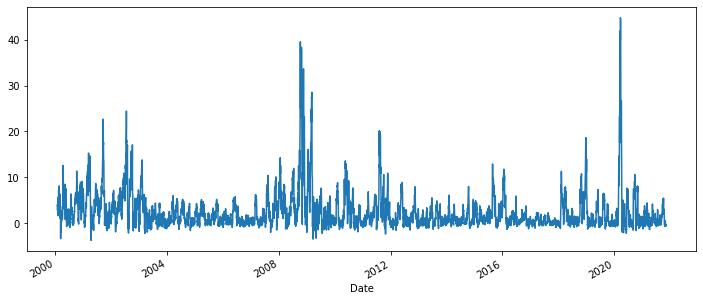

In [6]:
df['target'].plot.line(figsize=(12,5))

<AxesSubplot:>

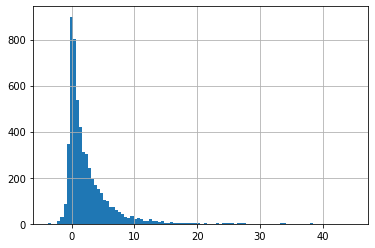

In [7]:
df['target'].hist(bins=100)

In [8]:
df['anomaly_label']=0
df.loc[df['target']>15, 'anomaly_label']=1

In [10]:
train_data = TimeSeries.from_pd(df[['target']].iloc[:-200])
train_labels = TimeSeries.from_pd(df[['anomaly_label']].iloc[:-200])
test_data = TimeSeries.from_pd(df[['target']].iloc[-200:])
test_labels = TimeSeries.from_pd(df[['anomaly_label']].iloc[-200:])

Model Initialization
In this notebook, we will use three different anomaly detection models:

Isolation Forest (a classic anomaly detection model)
WindStats (an in-house model that divides each week into windows of a specified size, and compares time series values to the historical values in the appropriate window)
Prophet (Facebook's popular forecasting model, adapted for anomaly detection.
Let's start by initializing each of them:

In [11]:
# Import models & configs
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig
from merlion.models.anomaly.windstats import WindStats, WindStatsConfig
# Import a post-rule for thresholding
from merlion.post_process.threshold import AggregateAlarms

# Import a data processing transform
from merlion.transform.moving_average import DifferenceTransform

# All models are initialized using the syntax ModelClass(config), where config
# is a model-specific configuration object. This is where you specify any
# algorithm-specific hyperparameters, any data pre-processing transforms, and
# the post-rule you want to use to post-process the anomaly scores (to reduce
# noisiness when firing alerts). 

# We initialize isolation forest using the default config
config1 = IsolationForestConfig()
model1  = IsolationForest(config1)

# We use a WindStats model that splits each week into windows of 60 minutes
# each. Anomaly scores in Merlion correspond to z-scores. By default, we would
# like to fire an alert for any 4-sigma event, so we specify a threshold rule
# which achieves this.
config2 = WindStatsConfig(wind_sz=60, threshold=AggregateAlarms(alm_threshold=4))
model2  = WindStats(config2)

In [12]:
from merlion.models.ensemble.anomaly import DetectorEnsemble, DetectorEnsembleConfig

ensemble_config = DetectorEnsembleConfig(threshold=AggregateAlarms(alm_threshold=4))
ensemble = DetectorEnsemble(config=ensemble_config, models=[model1, model2])

Model Training
All anomaly detection models (and ensembles) share the same API for training. The train() method returns the model's predicted anomaly scores on the training data. Note that you may optionally specify configs that modify the protocol used to train the model's post-rule! You may optionally specify ground truth anomaly labels as well (if you have them), but they are not needed. We give examples of all these behaviors below.

In [13]:
from merlion.evaluate.anomaly import TSADMetric

# Train IsolationForest in the default way, using the ground truth anomaly labels
# to set the post-rule's threshold
print(f"Training {type(model1).__name__}...")
train_scores_1 = model1.train(train_data=train_data, anomaly_labels=train_labels)

# Train WindStats completely unsupervised (this retains our anomaly detection 
# default anomaly detection threshold of 4)
print(f"\nTraining {type(model2).__name__}...")
train_scores_2 = model2.train(train_data=train_data, anomaly_labels=None)


# We consider an unsupervised ensemble, which combines the anomaly scores
# returned by the models & sets a static anomaly detection threshold of 3.
print("\nTraining ensemble...")
ensemble_post_rule_train_config = dict(metric=None)
train_scores_e = ensemble.train(
    train_data=train_data, anomaly_labels=train_labels,
    post_rule_train_config=ensemble_post_rule_train_config,
)

print("Done!")

Training IsolationForest...

Training WindStats...

Training ensemble...
Done!


Model Inference
There are two ways to invoke an anomaly detection model: model.get_anomaly_score() returns the model's raw anomaly scores, while model.get_anomaly_label() returns the model's post-processed anomaly scores. The post-processing calibrates the anomaly scores to be interpretable as z-scores, and it also sparsifies them such that any nonzero values should be treated as an alert that a particular timestamp is anomalous.

In [14]:
# Here is a full example for the first model, IsolationForest
scores_1 = model1.get_anomaly_score(test_data)
scores_1_df = scores_1.to_pd()
print(f"{type(model1).__name__}.get_anomaly_score() nonzero values (raw)")
print(scores_1_df[scores_1_df.iloc[:, 0] != 0])
print()

labels_1 = model1.get_anomaly_label(test_data)
labels_1_df = labels_1.to_pd()
print(f"{type(model1).__name__}.get_anomaly_label() nonzero values (post-processed)")
print(labels_1_df[labels_1_df.iloc[:, 0] != 0])
print()

print(f"{type(model1).__name__} fires {(labels_1_df.values != 0).sum()} alarms")
print()

print("Raw scores at the locations where alarms were fired:")
print(scores_1_df[labels_1_df.iloc[:, 0] != 0])
print("Post-processed scores are interpretable as z-scores")
print("Raw scores are challenging to interpret")

IsolationForest.get_anomaly_score() nonzero values (raw)
            anom_score
2021-01-26    0.335409
2021-01-27    0.419614
2021-01-28    0.416315
2021-01-29    0.408352
2021-02-01    0.413427
...                ...
2021-11-01    0.334865
2021-11-02    0.332759
2021-11-03    0.332811
2021-11-04    0.339040
2021-11-05    0.335755

[199 rows x 1 columns]

IsolationForest.get_anomaly_label() nonzero values (post-processed)
Empty DataFrame
Columns: [anom_score]
Index: []

IsolationForest fires 0 alarms

Raw scores at the locations where alarms were fired:
Empty DataFrame
Columns: [anom_score]
Index: []
Post-processed scores are interpretable as z-scores
Raw scores are challenging to interpret


In [15]:

scores_2 = model2.get_anomaly_score(test_data)
labels_2 = model2.get_anomaly_label(test_data)

In [16]:
scores_e = ensemble.get_anomaly_score(test_data)
labels_e = ensemble.get_anomaly_label(test_data)

Quantitative Evaluation
It is fairly transparent to visualize a model's predicted anomaly scores and also quantitatively evaluate its anomaly labels. For evaluation, we use specialized definitions of precision, recall, and F1 as revised point-adjusted metrics (see the technical report for more details). We also consider the mean time to detect anomalies.

In general, you may use the TSADMetric enum to compute evaluation metrics for a time series using the syntax

TSADMetric.<metric_name>.value(ground_truth=ground_truth, predict=anomaly_labels)
where <metric_name> is the name of the evaluation metric (see the API docs for details and more options), ground_truth is a time series of ground truth anomaly labels, and anomaly_labels is the output of model.get_anomaly_label().

In [17]:
from merlion.evaluate.anomaly import TSADMetric

for model, labels in [(model1, labels_1), (model2, labels_2),  (ensemble, labels_e)]:
    print(f"{type(model).__name__}")
    precision = TSADMetric.Precision.value(ground_truth=test_labels, predict=labels)
    recall = TSADMetric.Recall.value(ground_truth=test_labels, predict=labels)
    f1 = TSADMetric.F1.value(ground_truth=test_labels, predict=labels)
    mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels, predict=labels)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"MTTD:      {mttd}")
    print()

IsolationForest
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
MTTD:      0 days 00:00:00

WindStats
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
MTTD:      0 days 00:00:00

DetectorEnsemble
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
MTTD:      0 days 00:00:00



Model Visualization
Let's now visualize the model predictions that led to these outcomes. The option filter_scores=True means that we want to plot the post-processed anomaly scores (i.e. returned by model.get_anomaly_label()). You may instead specify filter_scores=False to visualize the raw anomaly scores.

IsolationForest


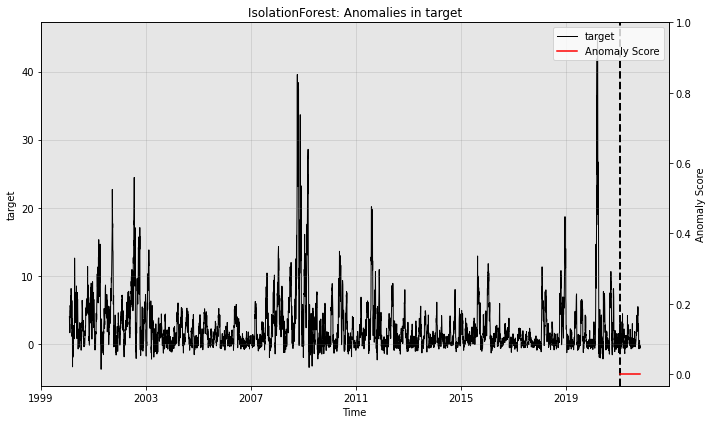


WindStats


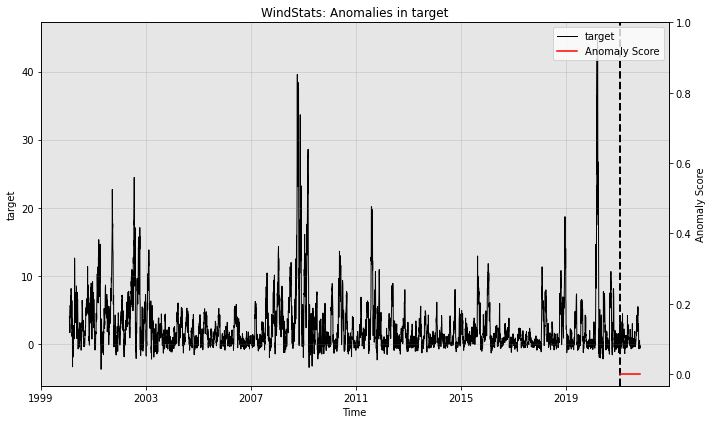

In [20]:
for model in [model1, model2]:
    print(type(model).__name__)
    fig, ax = model.plot_anomaly(
        time_series=test_data, time_series_prev=train_data,
        filter_scores=True, plot_time_series_prev=True)
    plot_anoms(ax=ax, anomaly_labels=test_labels)
    plt.show()
    print()

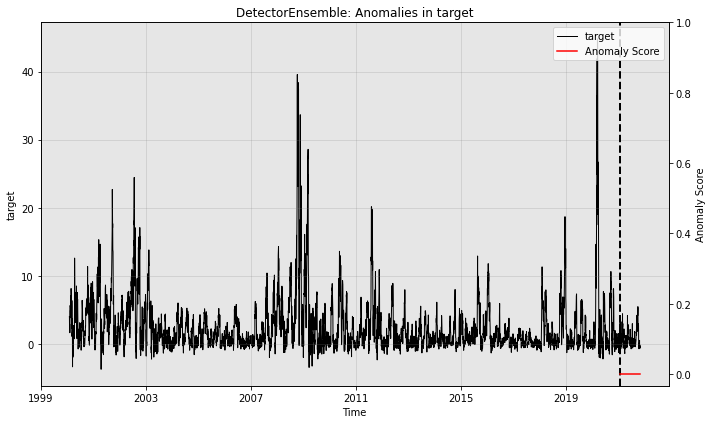

In [21]:
fig, ax = ensemble.plot_anomaly(
    time_series=test_data, time_series_prev=train_data,
    filter_scores=True, plot_time_series_prev=True)
plot_anoms(ax=ax, anomaly_labels=test_labels)
plt.show()

Saving & Loading Models
All models have a save() method and load() class method. Models may also be loaded with the assistance of the ModelFactory, which works for arbitrary models. The save() method creates a new directory at the specified path, where it saves a json file representing the model's config, as well as a binary file for the model's state.

We will demonstrate these behaviors using our IsolationForest model (model1) for concreteness. Note that the config explicitly tracks the transform (to pre-process the data), the calibrator (to transform raw anomaly scores into z-scores), the thresholding rule (to sparsify the calibrated anomaly scores).

In [22]:
import json
import os
import pprint
from merlion.models.factory import ModelFactory

# Save the model
os.makedirs("models", exist_ok=True)
path = os.path.join("models", "isf")
model1.save(path)

# Print the config saved
pp = pprint.PrettyPrinter()
with open(os.path.join(path, "config.json")) as f:
    print(f"{type(model1).__name__} Config")
    pp.pprint(json.load(f))

# Load the model using Prophet.load()
model2_loaded = IsolationForest.load(dirname=path)

# Load the model using the ModelFactory
model2_factory_loaded = ModelFactory.load(name="IsolationForest", model_path=path)

IsolationForest Config
{'calibrator': {'abs_score': True,
                'anchors': [[0.329484610288735, 0.0],
                            [0.3461521926872695, 0.5],
                            [0.36903995404472845, 1.0],
                            [0.4117510611629981, 1.5],
                            [0.48412523537656327, 2.0],
                            [0.8389017708292964, 4.140317145679946],
                            [1.0, 5.140317145679946]],
                'max_score': 1.0,
                'name': 'AnomScoreCalibrator'},
 'enable_calibrator': True,
 'enable_threshold': True,
 'max_n_samples': 1.0,
 'model_path': 'C:\\Users\\libin.chen\\Documents\\00_python_scripts\\north_star\\regime_shift\\models\\isf\\model.pkl',
 'n_estimators': 100,
 'threshold': {'abs_score': True,
               'alm_suppress_minutes': 120,
               'alm_threshold': 2.814211687224648,
               'alm_window_minutes': 60,
               'min_alm_in_window': 2,
               'name': 'Aggrega

In [23]:
# Save the ensemble
path = os.path.join("models", "ensemble")
ensemble.save(path)

# Print the config saved. Note that we've saved all individual models,
# and their paths are specified under the model_paths key.
pp = pprint.PrettyPrinter()
with open(os.path.join(path, "config.json")) as f:
    print(f"Ensemble Config")
    pp.pprint(json.load(f))

# Load the selector
selector_loaded = DetectorEnsemble.load(dirname=path)

# Load the selector using the ModelFactory
selector_factory_loaded = ModelFactory.load(name="DetectorEnsemble", model_path=path)

Ensemble Config
{'calibrator': {'abs_score': True,
                'anchors': None,
                'max_score': 1000,
                'name': 'AnomScoreCalibrator'},
 'combiner': {'abs_score': True, 'n_models': 2, 'name': 'Mean'},
 'enable_calibrator': False,
 'enable_threshold': True,
 'model_paths': [['IsolationForest',
                  'C:\\Users\\libin.chen\\Documents\\00_python_scripts\\north_star\\regime_shift\\models\\ensemble\\0'],
                 ['WindStats',
                  'C:\\Users\\libin.chen\\Documents\\00_python_scripts\\north_star\\regime_shift\\models\\ensemble\\1']],
 'threshold': {'abs_score': True,
               'alm_suppress_minutes': 120,
               'alm_threshold': 4,
               'alm_window_minutes': 60,
               'min_alm_in_window': 2,
               'name': 'AggregateAlarms'},
 'transform': {'name': 'Identity'}}
